# This notebook is designed to create the Time Series forecast for the entirety of the historical data.



In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [42]:
df = pd.read_csv('Total_Net_Gross_Profit.csv')
df = df.set_index('Transaction Date')
df.index = pd.to_datetime(df.index)

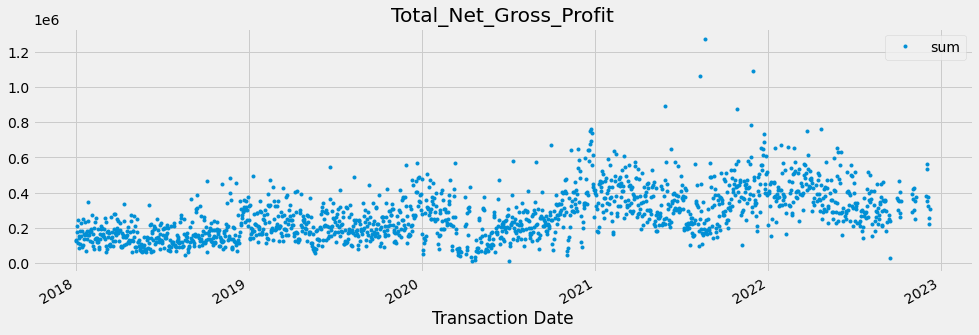

In [43]:
"""
Creating a plot to see the total net gross profit from the given sales_daily dataset

"""



df.plot(style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title='Total_Net_Gross_Profit')
plt.show()

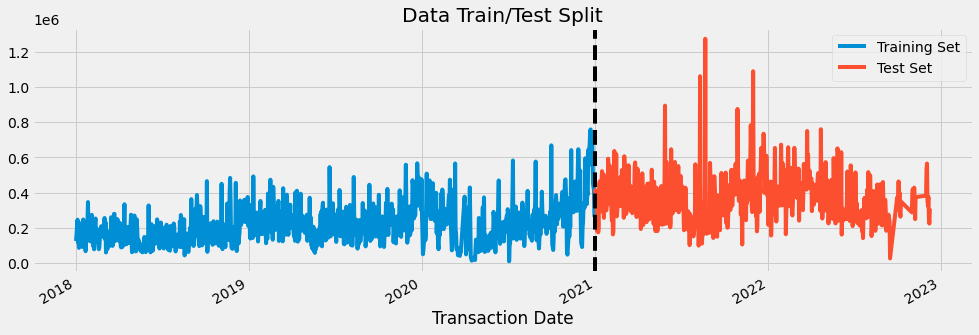

In [44]:
train = df.loc[df.index < '01-01-2021']  # Assigning the training set
test = df.loc[df.index >= '01-01-2021']  # Assigning the testing set

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2021', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

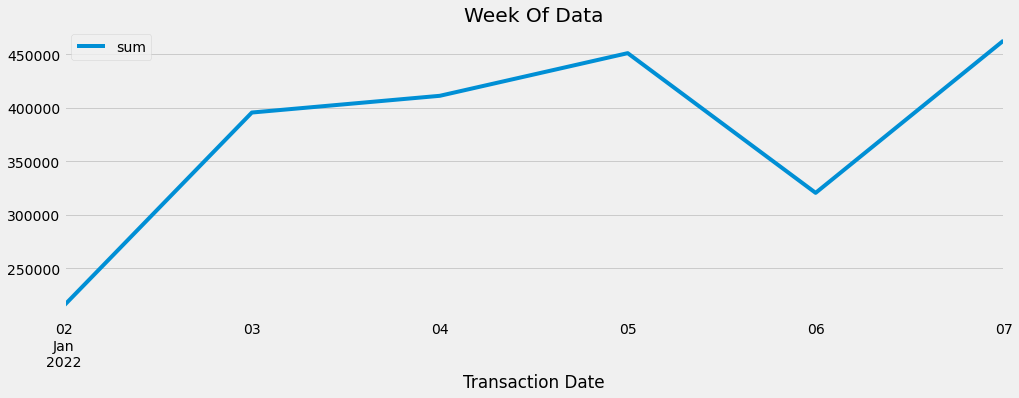

In [45]:
# This shows an example of a week of data, it is only included to show an example of how this can be performed

df.loc[(df.index > '01-01-2022') & (df.index < '01-08-2022')] \
    .plot(figsize=(15, 5), title='Week Of Data')
plt.show()

In [46]:
"""
Creating the features that will be used to improve the model's accuracy

"""

def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)

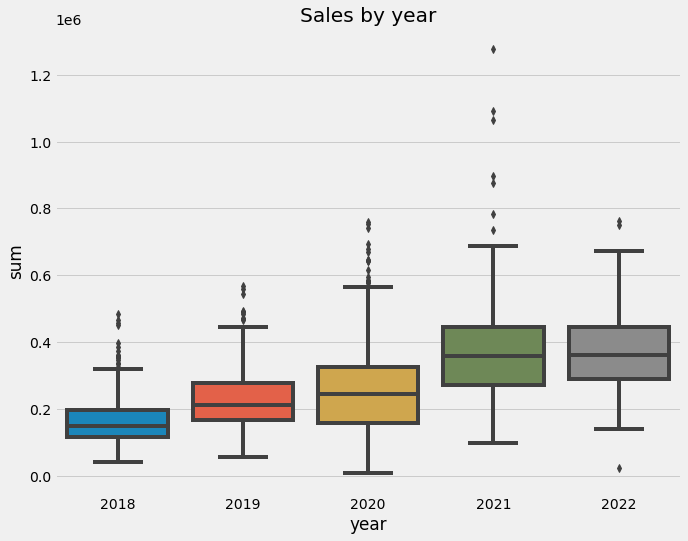

In [48]:
# A box plot showing the sales performance from the historical data, on a yearly basis

fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='year', y='sum')
ax.set_title('Sales by year')
plt.show()

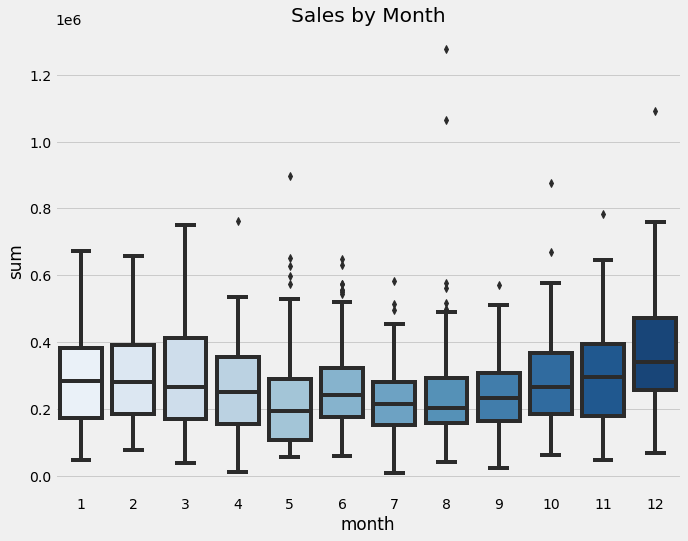

In [49]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='month', y='sum', palette='Blues')
ax.set_title('Sales by Month')
plt.show()

## The XGBoost Time Series Forecast Model

In [50]:
"""
Training and testing the model using the features that were created earlier

"""

train = create_features(train)
test = create_features(test)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year']
TARGET = 'sum'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [ ]:
# Running the model

reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

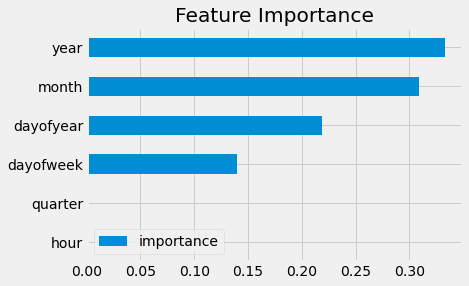

In [52]:
# Showing the impact of each feature

fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

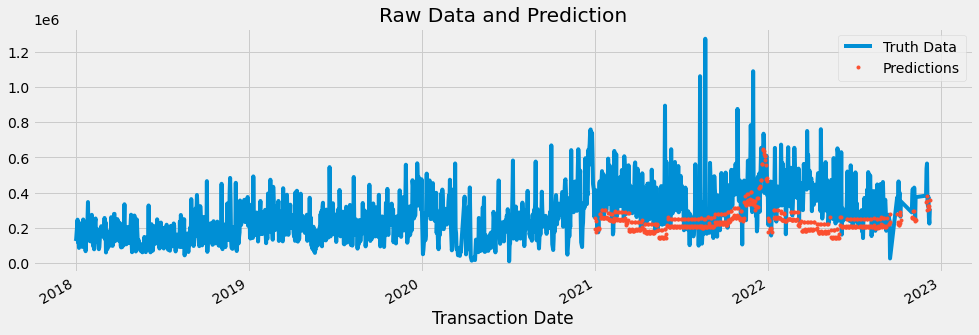

In [55]:
# Creating a plot with the prediction model overlaping the actual data

test['prediction'] = reg.predict(X_test)
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = df[['sum']].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Data and Prediction')
plt.show()

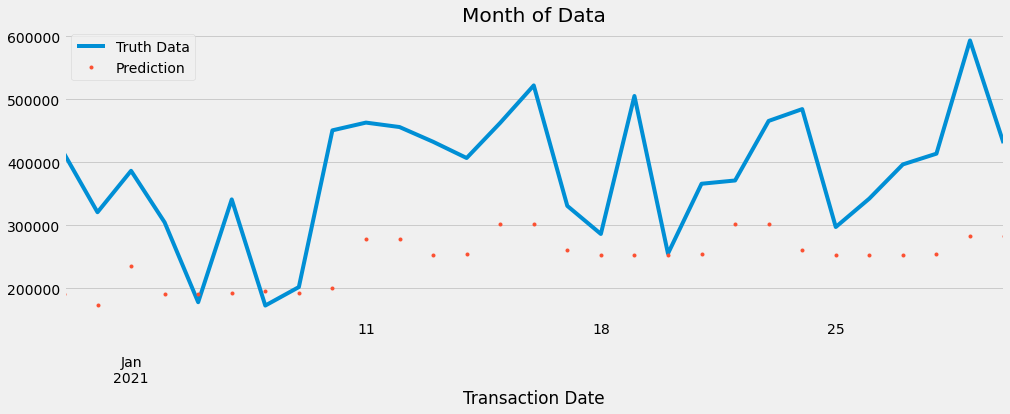

In [57]:
# Showing the models performance in a month of data

ax = df.loc[(df.index > '01-01-2021') & (df.index < '31-01-2021')]['sum'] \
    .plot(figsize=(15, 5), title='Month of Data')
df.loc[(df.index > '01-01-2021') & (df.index < '31-01-2021')]['prediction'] \
    .plot(style='.')
plt.legend(['Truth Data','Prediction'])
plt.show()



#### Model Performance

In [58]:
score = np.sqrt(mean_squared_error(test['sum'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 185084.86


In [59]:
test['error'] = np.abs(test[TARGET] - test['prediction'])
test['date'] = test.index.date
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10)

date
2021-08-22    1.068958e+06
2021-08-11    8.571413e+05
2021-12-01    7.528389e+05
2021-05-29    7.063299e+05
2021-10-29    5.633363e+05
2022-04-23    5.419351e+05
2022-03-25    5.181484e+05
2022-05-29    4.802950e+05
2022-05-28    4.628366e+05
2022-03-27    4.225496e+05
Name: error, dtype: float64

<AxesSubplot:ylabel='Frequency'>

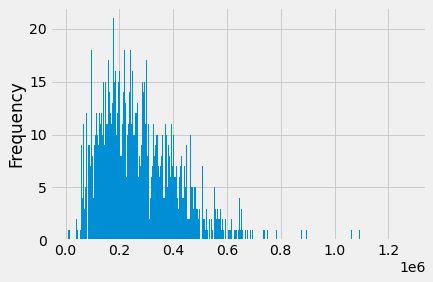

In [60]:
# To examine if there are outliers that can be removed from the model

df['sum'].plot(kind='hist', bins=500)

## Creating a more accurate model for the future predictions, using time series cross validation

In [61]:
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits=4, test_size=365*1, gap=1)
df = df.sort_index()



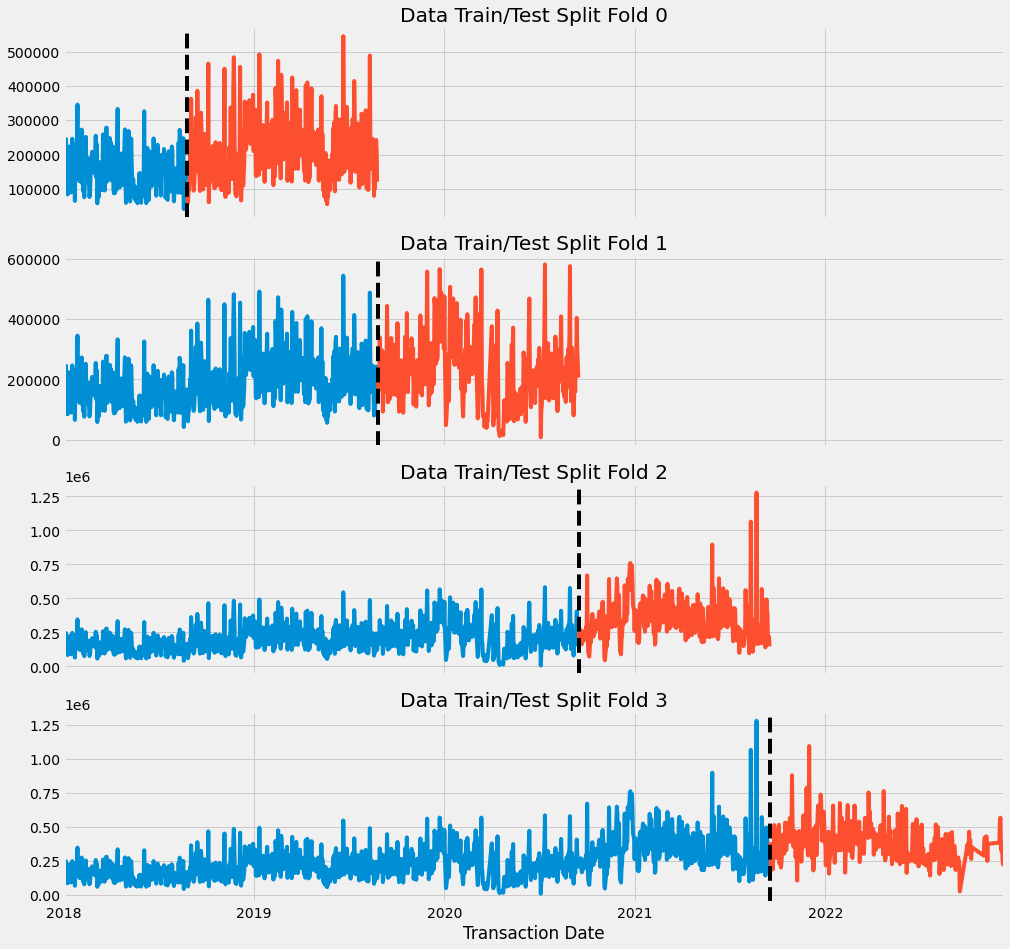

In [63]:
fig, axs = plt.subplots(4, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train['sum'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test['sum'].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()

In [64]:
"""
Adding lag features to improve the model

"""

def add_lags(df):
    target_map = df['sum'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('364 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('546 days')).map(target_map)
    return df

In [65]:
df = add_lags(df)

## Training the model using cross validation

In [ ]:
tss = TimeSeriesSplit(n_splits=4, test_size=365*1, gap=1)
df = df.sort_index()


fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    train = create_features(train)
    test = create_features(test)

    FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month','year',
                'lag1','lag2']
    TARGET = 'sum'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=3,
                           learning_rate=0.01)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

In [67]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across folds 130791.3792
Fold scores:[103855.41337649035, 110666.08589246165, 184566.4464875494, 124077.57115029541]


In [ ]:
df = create_features(df)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year',
            'lag1','lag2']
TARGET = 'sum'

X_all = df[FEATURES]
y_all = df[TARGET]

reg = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',    
                       n_estimators=650,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_all, y_all,
        eval_set=[(X_all, y_all)],
        verbose=100)

In [69]:
df.index.max()

Timestamp('2022-12-09 00:00:00')

In [70]:
#Creating a plot for the predictions

future = pd.date_range('2022-12-09','2024-06-09', freq='24h')
future_df = pd.DataFrame(index=future)
future_df['isFuture'] = True
df['isFuture'] = False
df_and_future = pd.concat([df, future_df])
df_and_future = create_features(df_and_future)
df_and_future = add_lags(df_and_future)

In [71]:
future_w_features = df_and_future.query('isFuture').copy()

In [72]:
future_w_features['pred'] = reg.predict(future_w_features[FEATURES])

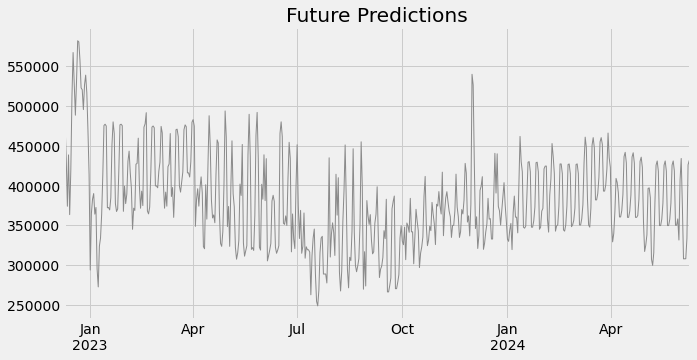

In [73]:
future_w_features['pred'].plot(figsize=(10, 5),
                               color=color_pal[4],
                               ms=1,
                               lw=1,
                               title='Future Predictions')
plt.show()

##### Merging the historical data with the predicted data to provide a final graph showing the future sales forecast

In [74]:
future_w_features

,sum,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,prediction_x,prediction_y,prediction,lag1,lag2,isFuture,pred
2022-12-09,NaN,0,4,4,12,2022,343,9,49,NaN,NaN,NaN,208382.7908,647075.2772,True,318392.43750
2022-12-10,NaN,0,5,4,12,2022,344,10,49,NaN,NaN,NaN,490560.5823,342982.0647,True,476206.81250
2022-12-11,NaN,0,6,4,12,2022,345,11,49,NaN,NaN,NaN,410723.8489,352916.5041,True,433286.90625
2022-12-12,NaN,0,0,4,12,2022,346,12,50,NaN,NaN,NaN,384980.9829,281291.6000,True,373772.78125
2022-12-13,NaN,0,1,4,12,2022,347,13,50,NaN,NaN,NaN,508467.0821,389830.7598,True,438339.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-05,NaN,0,2,2,6,2024,157,5,23,NaN,NaN,NaN,NaN,257193.8051,True,307805.78125
2024-06-06,NaN,0,3,2,6,2024,158,6,23,NaN,NaN,NaN,NaN,222751.0334,True,333562.34375
2024-06-07,NaN,0,4,2,6,2024,159,7,23,NaN,NaN,NaN,NaN,NaN,True,425843.62500
2024-06-08,NaN,0,5,2,6,2024,160,8,23,NaN,NaN,NaN,NaN,NaN,True,431135.18750


In [81]:
col1 = future_w_features['pred']
Prediction_df = pd.DataFrame({'sum': col1})

Prediction_df

,sum
2022-12-09,318392.43750
2022-12-10,476206.81250
2022-12-11,433286.90625
2022-12-12,373772.78125
2022-12-13,438339.00000
...,...
2024-06-05,307805.78125
2024-06-06,333562.34375
2024-06-07,425843.62500
2024-06-08,431135.18750


In [82]:
Historical_Pred_df = pd.concat([df, Prediction_df], axis=0)

In [83]:
Historical_Pred_df

,sum,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,prediction_x,prediction_y,prediction,lag1,lag2,isFuture
2018-01-01,122490.19250,0.0,0.0,1.0,1.0,2018.0,1.0,1.0,1,NaN,NaN,NaN,NaN,NaN,False
2018-01-02,130188.73960,0.0,1.0,1.0,1.0,2018.0,2.0,2.0,1,NaN,NaN,NaN,NaN,NaN,False
2018-01-03,172332.89000,0.0,2.0,1.0,1.0,2018.0,3.0,3.0,1,NaN,NaN,NaN,NaN,NaN,False
2018-01-04,208073.52870,0.0,3.0,1.0,1.0,2018.0,4.0,4.0,1,NaN,NaN,NaN,NaN,NaN,False
2018-01-05,245056.67130,0.0,4.0,1.0,1.0,2018.0,5.0,5.0,1,NaN,NaN,NaN,NaN,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-05,307805.78125,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,NaN,NaN,NaN,NaN,NaN,NaN
2024-06-06,333562.34375,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,NaN,NaN,NaN,NaN,NaN,NaN
2024-06-07,425843.62500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,NaN,NaN,NaN,NaN,NaN,NaN
2024-06-08,431135.18750,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,NaN,NaN,NaN,NaN,NaN,NaN


In [84]:
Historical_Pred_df = Historical_Pred_df[['sum']]

In [85]:
Historical_Pred_df

,sum
2018-01-01,122490.19250
2018-01-02,130188.73960
2018-01-03,172332.89000
2018-01-04,208073.52870
2018-01-05,245056.67130
...,...
2024-06-05,307805.78125
2024-06-06,333562.34375
2024-06-07,425843.62500
2024-06-08,431135.18750


In [86]:
Historical_Pred_df.rename_axis("Transaction Date", axis=0, inplace=True)

In [87]:
Historical_Pred_df.to_csv('Historical_Pred_df_NetGrossProfit.csv', index=True)

In [88]:
df_Prediction = pd.read_csv('Historical_Pred_df_NetGrossProfit.csv')
df_Prediction = df_Prediction.set_index('Transaction Date')
df_Prediction.index = pd.to_datetime(df_Prediction.index)

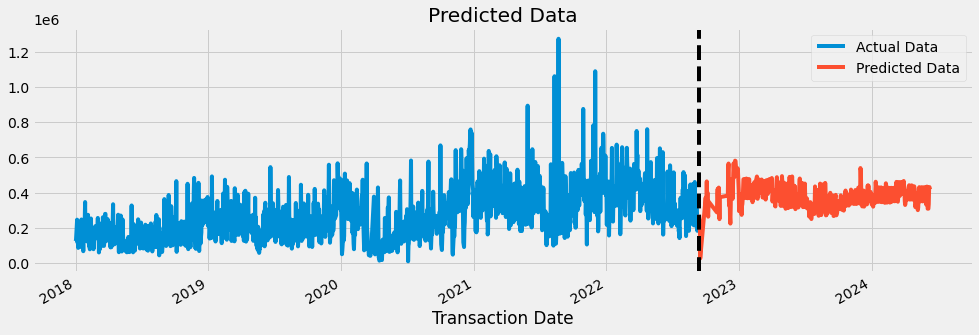

In [89]:
Actual = Historical_Pred_df.loc[df_Prediction.index < '09-12-2022']
Prediction = Historical_Pred_df.loc[df_Prediction.index >= '9-12-2022']

fig, ax = plt.subplots(figsize=(15, 5))
Actual.plot(ax=ax, label='Actual Data', title='Predicted Data')
Prediction.plot(ax=ax, label='Predicted Data')
ax.axvline('09-12-2022', color='black', ls='--')
ax.legend(['Actual Data', 'Predicted Data'])
plt.show()